### `geom_imshow()` renders `NaN` values as transparent pixels

In [1]:
import numpy as np
from osgeo import gdal, osr

from lets_plot import *

In [2]:
LetsPlot.setup_html()

In [3]:
def get_bounds(data):
    xmin, xpixel, _, ymax, _, ypixel = data.GetGeoTransform()
    width, height = data.RasterXSize, data.RasterYSize
    xmax = xmin + width * xpixel
    ymin = ymax + height * ypixel
    return xmin, ymin, xmax, ymax

def get_crs(data):
    proj = osr.SpatialReference(wkt=data.GetProjection())
    return "EPSG:{0}".format(proj.GetAttrValue('AUTHORITY', 1))

#### Load Data - Japan Digital Elevation Model (DEM)

Data are available at

[Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28762)

Japan DEM (c) USGS. Processed for Japan by Skinner Regional Systems Analysis. Cambridge: Center for Geographic Analysis, Harvard University, 2015.

In [4]:
# Load data with GDAL

jp_tif = gdal.Open("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/japan_dem_wgs84/japan_dem_wgs84.tif")

In [5]:
# Metadata

jp_crs = get_crs(jp_tif)
jp_bounds = get_bounds(jp_tif)

print("{}\n{}".format(jp_crs, jp_bounds))

EPSG:4326
(127.9421598662918, 29.201489591057303, 155.88170436191123, 50.02079185141284)


In [6]:
# create the "extent" to use in geom_imshow()

xmin = jp_bounds[0]
xmax = jp_bounds[2]
ymin = jp_bounds[1]
ymax = jp_bounds[3]

jp_ext=[xmin, xmax, ymin, ymax]

In [7]:
# Get the first band as a 2D numpy array

jp_arr = jp_tif.GetRasterBand(1).ReadAsArray()

In [8]:
type(jp_arr), np.shape(jp_arr)

(numpy.ndarray, (2038, 2735))


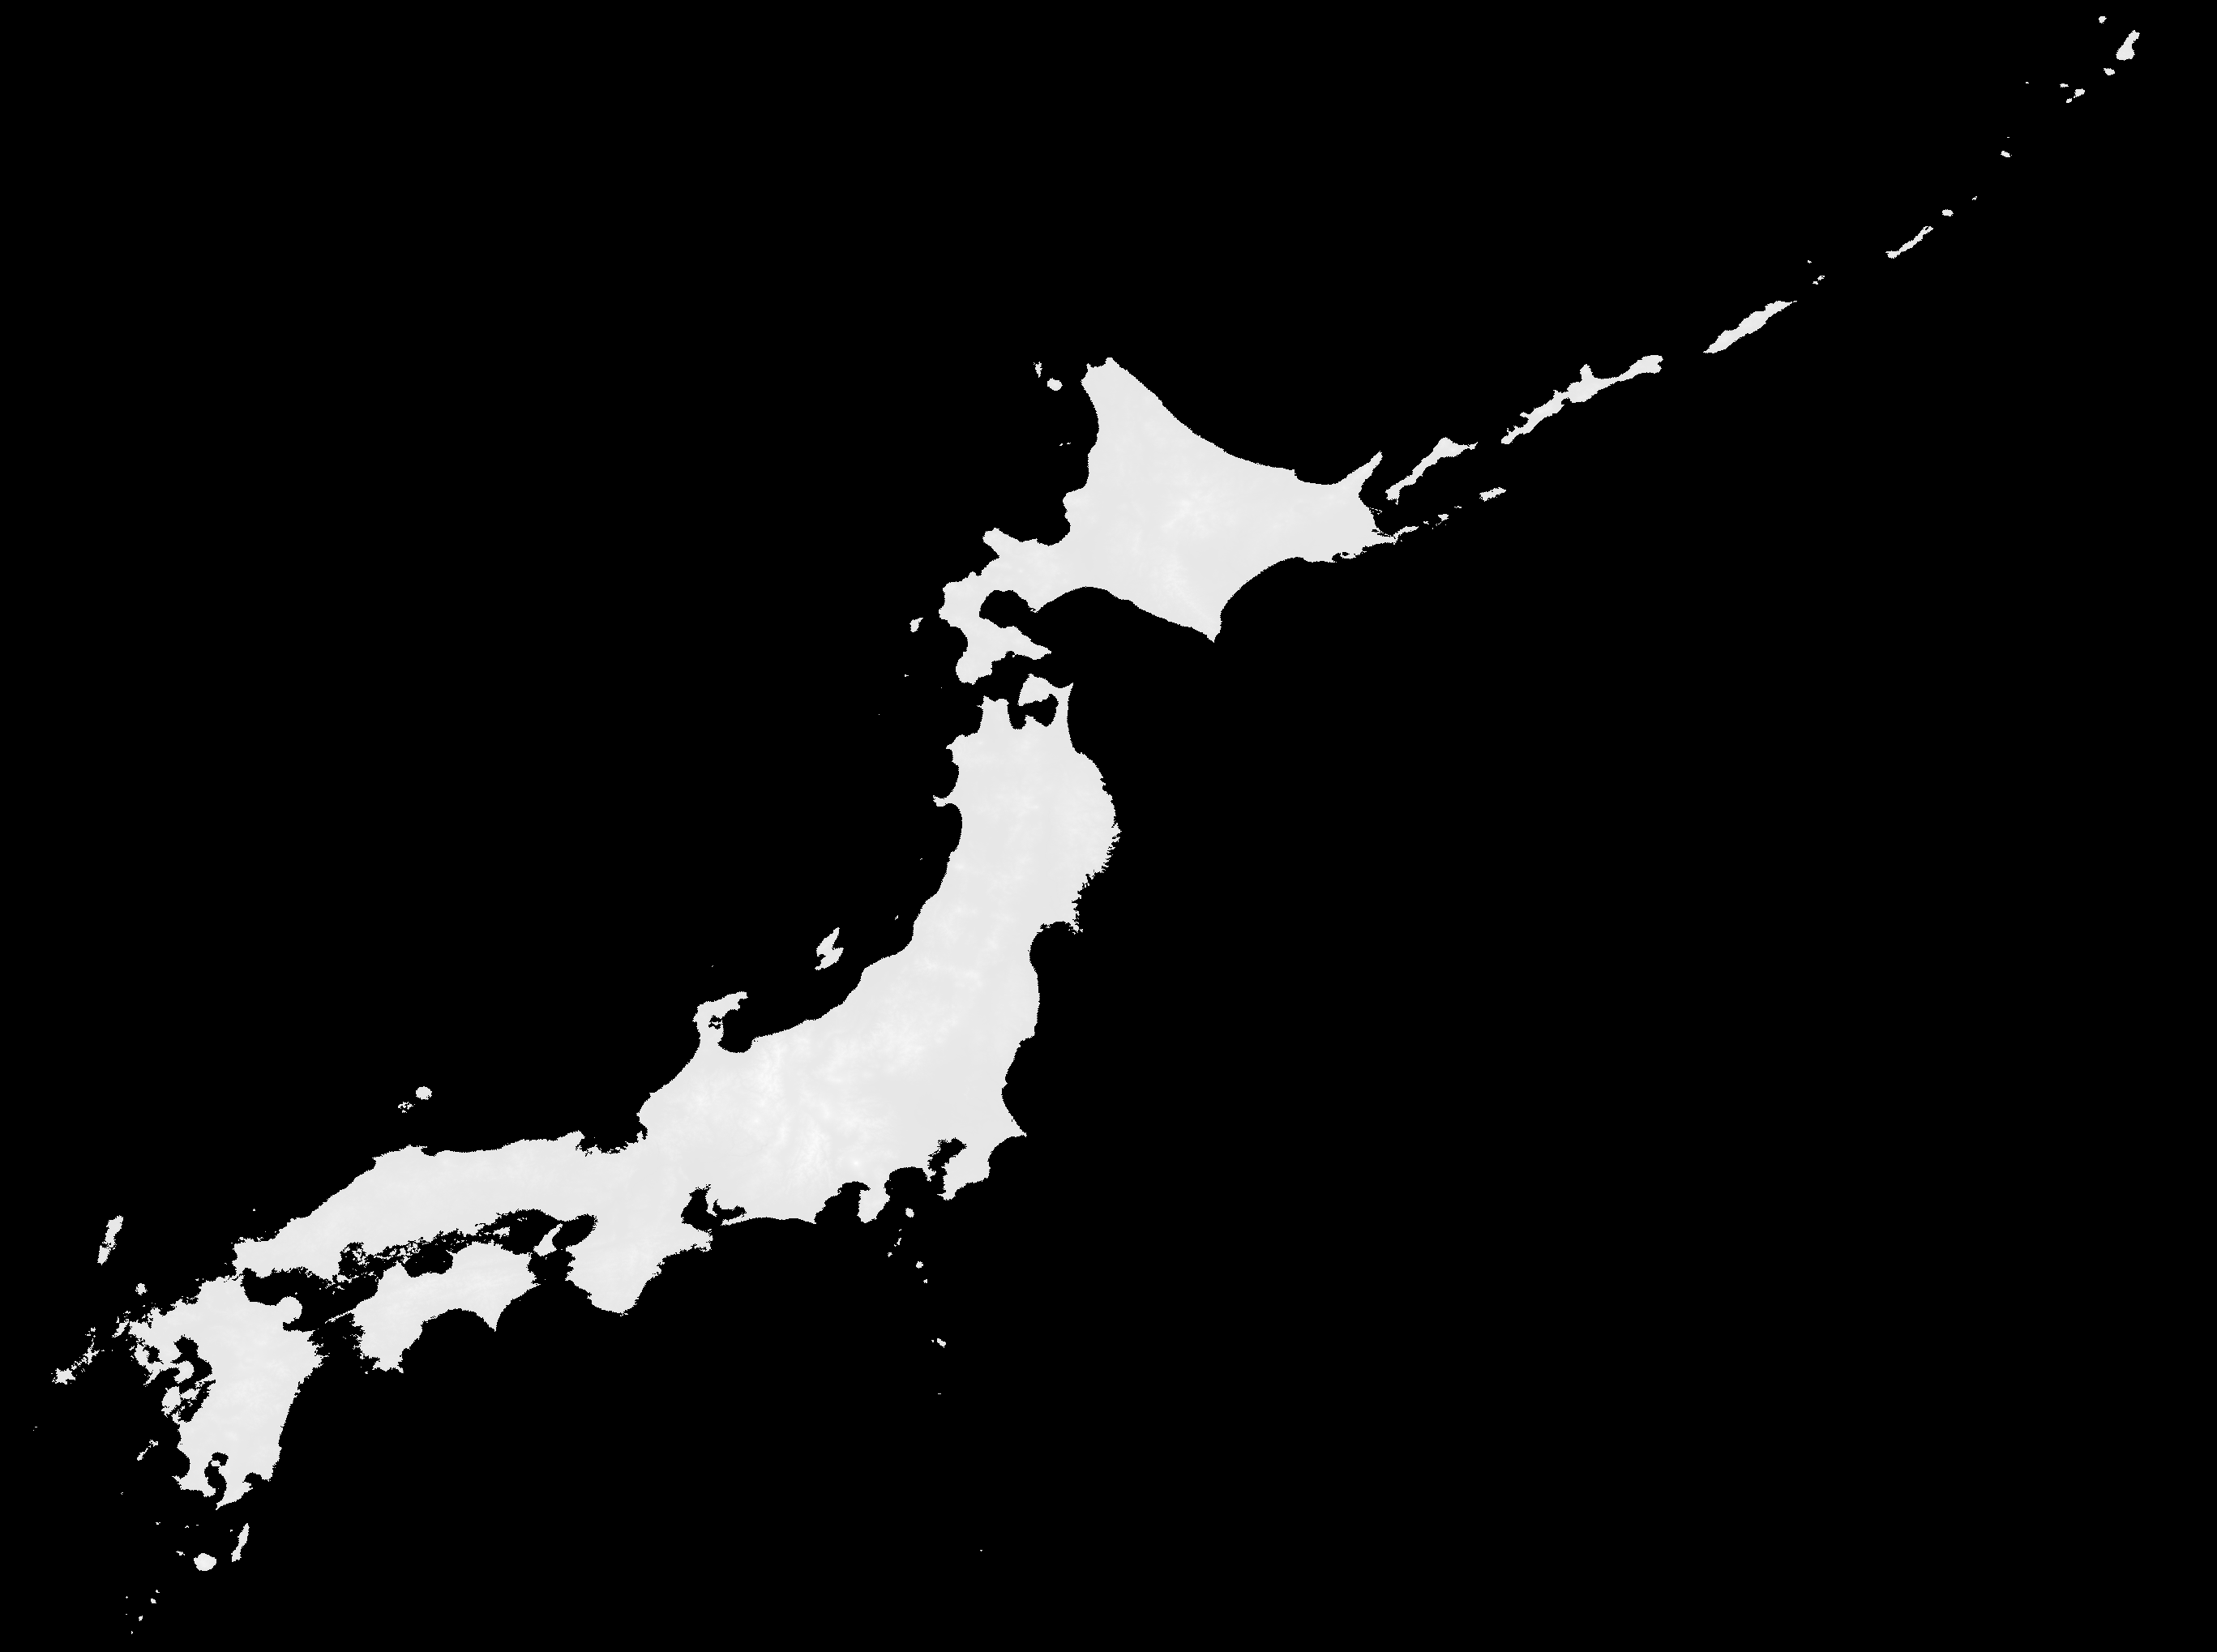

In [9]:
ggplot() + geom_imshow(jp_arr, extent=jp_ext)

Easy to see (chart below) that values in `jp_arr` form 2 clusters: large negative values and values close to 0. 

After "normalization", those 2 clasters fall into opposite sides of the luminosity spectrum, and as result we can only see blak&wite picture.

In [10]:
(ggplot() 
 + geom_histogram(aes(x=jp_arr.flatten()))
 + geom_vline(xintercept=-32768, color="red")
 + geom_label(label="-32768", x=-30000, y=5.2E6)
 + ggtitle("Distribution of elevations in Japan DEM")
 + xlab("elevation (m)")
)

### Re-encode the sea level using `NaN` values

The sea level elevation is traditionally encoded as minimal 16-bit value: -32768. 

In [11]:
jp_arr_nan=jp_arr.copy().astype(np.float32)
jp_arr_nan[jp_arr<-30000]=np.nan

(ggplot() 
 + geom_histogram(aes(x=jp_arr_nan.flatten()))
 + ggtitle("Distribution of elevations in Japan DEM", subtitle="excluding 'sea level'")
 + xlab("elevation (m)")
)

### Sea level is now transparent


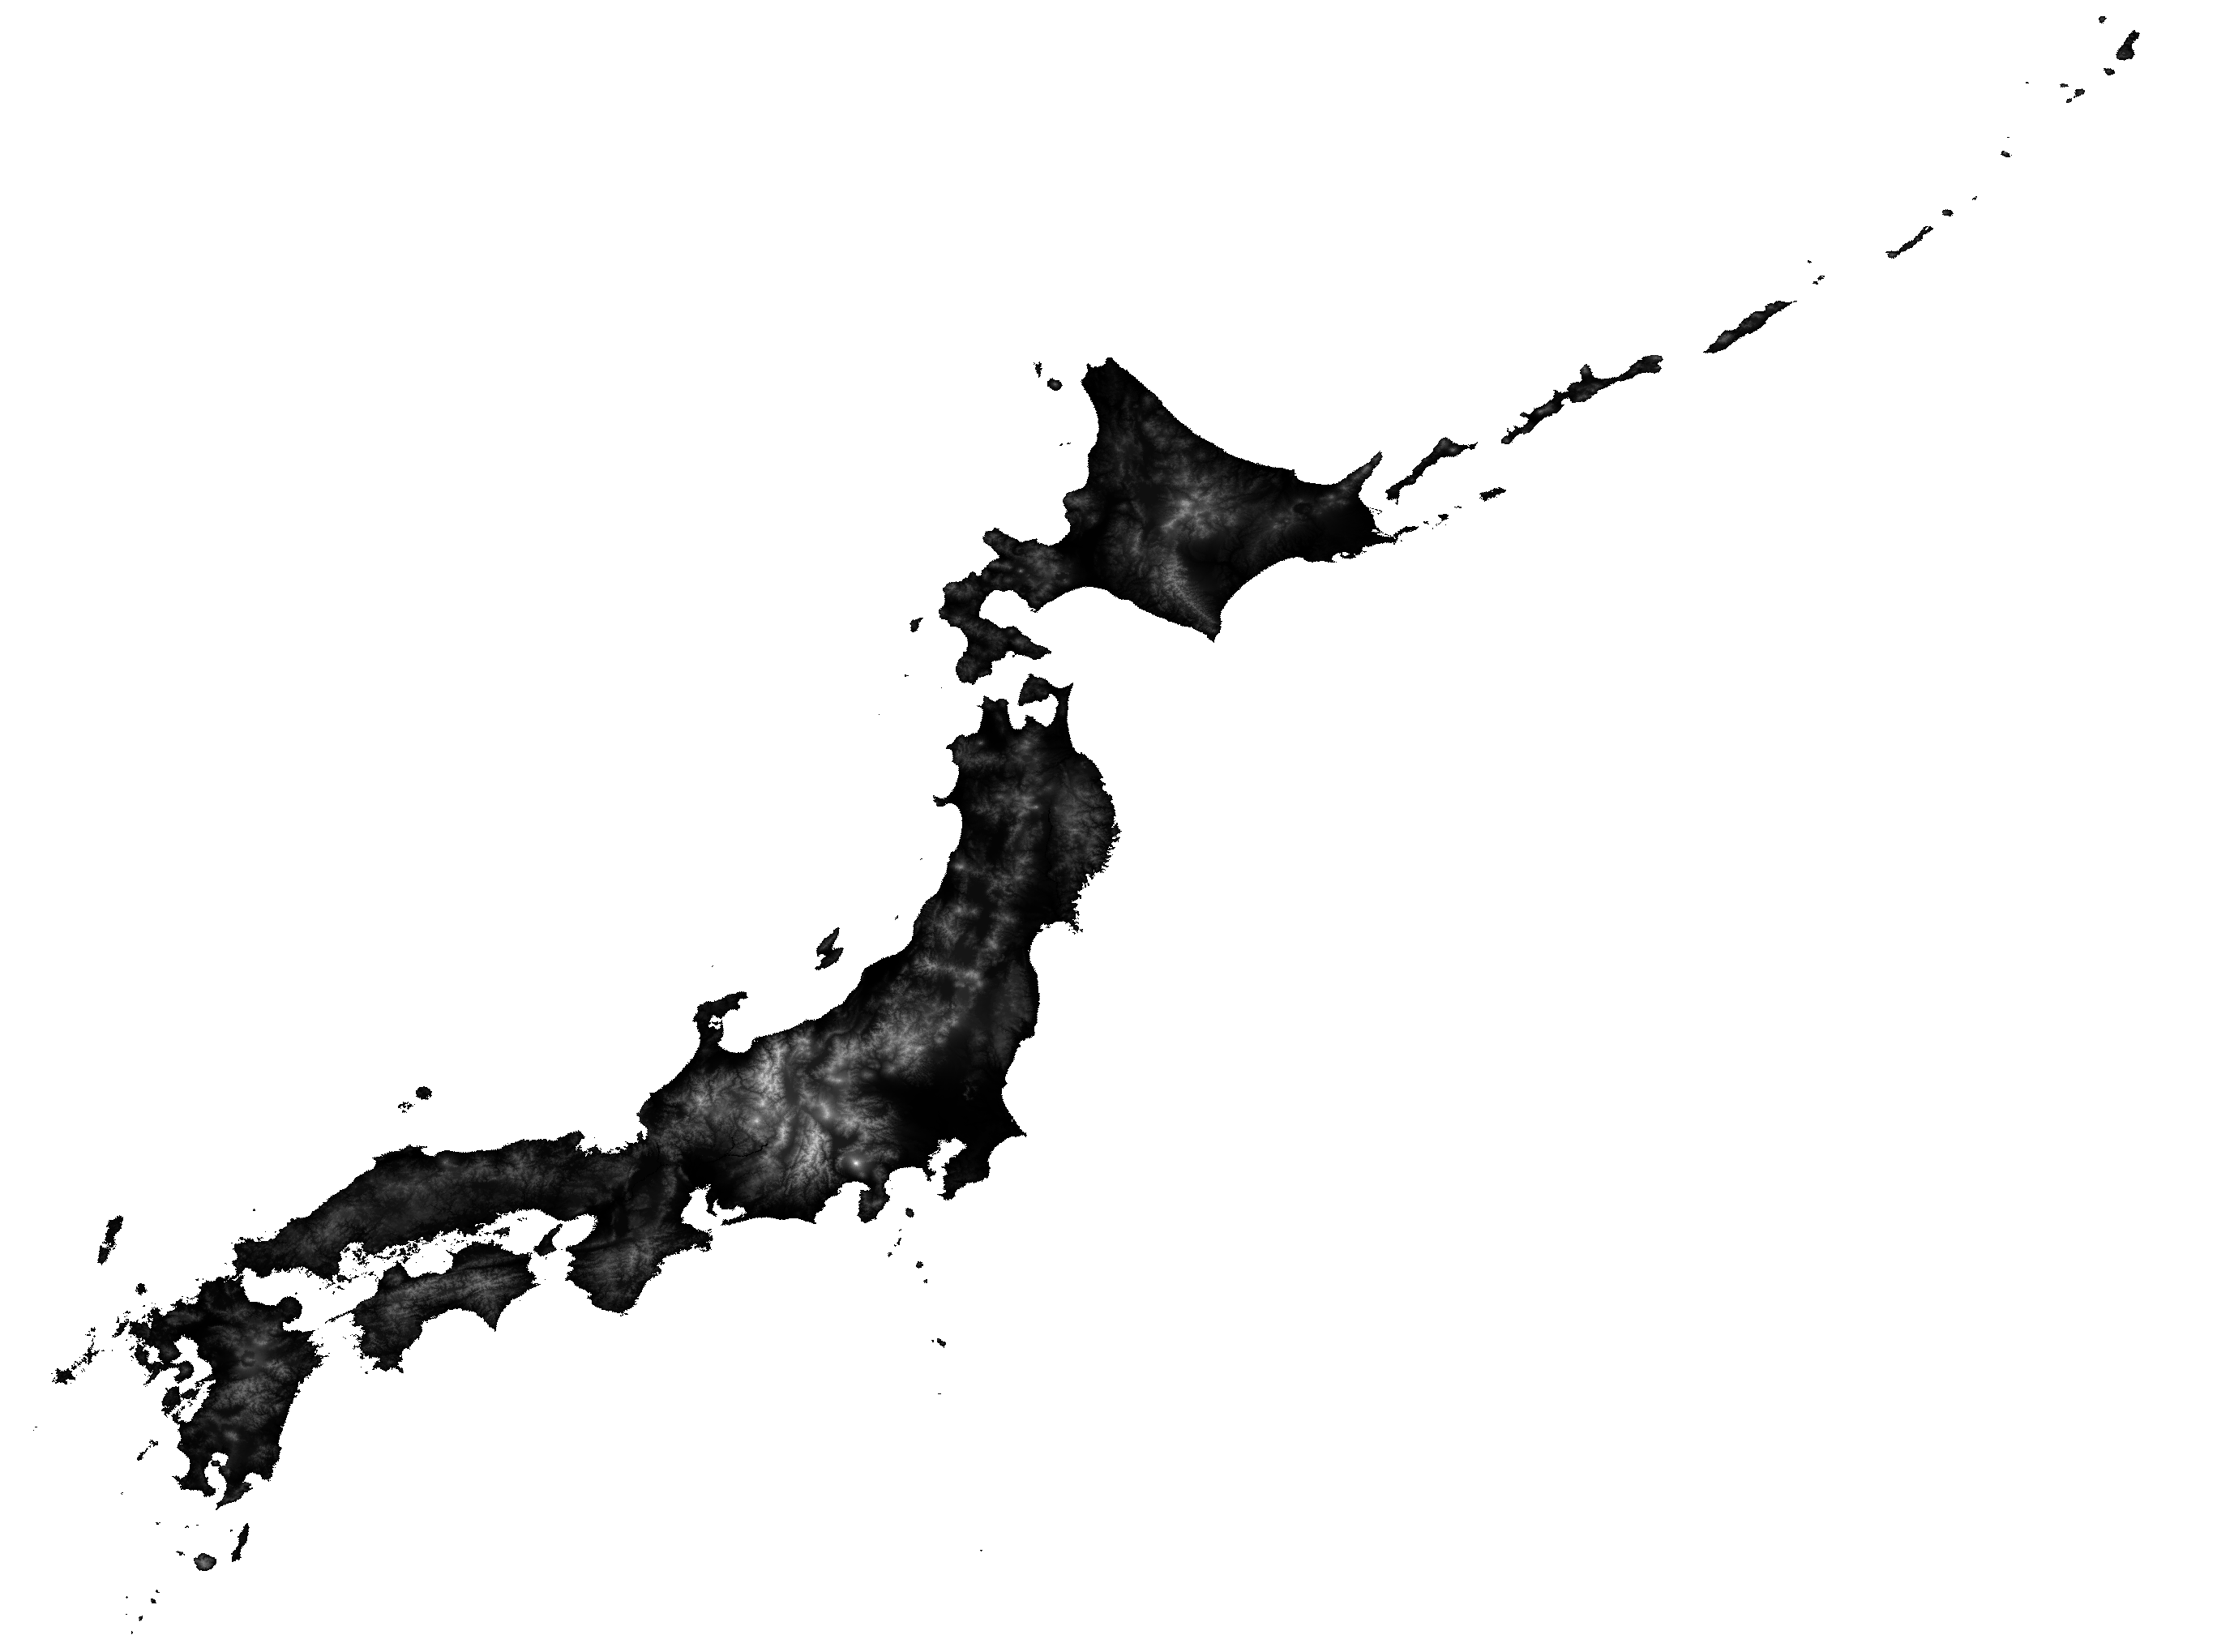

In [12]:
ggplot() + geom_imshow(jp_arr_nan, extent=jp_ext)

In [13]:
jp_bbox = dict(zip(['xmin', 'ymin', 'xmax', 'ymax'], jp_bounds))
jp_bbox

{'xmin': 127.9421598662918,
 'ymin': 29.201489591057303,
 'xmax': 155.88170436191123,
 'ymax': 50.02079185141284}

In [14]:
labels = dict(
    label=["Sea of Japan", "Pacific\nOcean"],
    x=[134, 144],
    y=[41, 33]
)


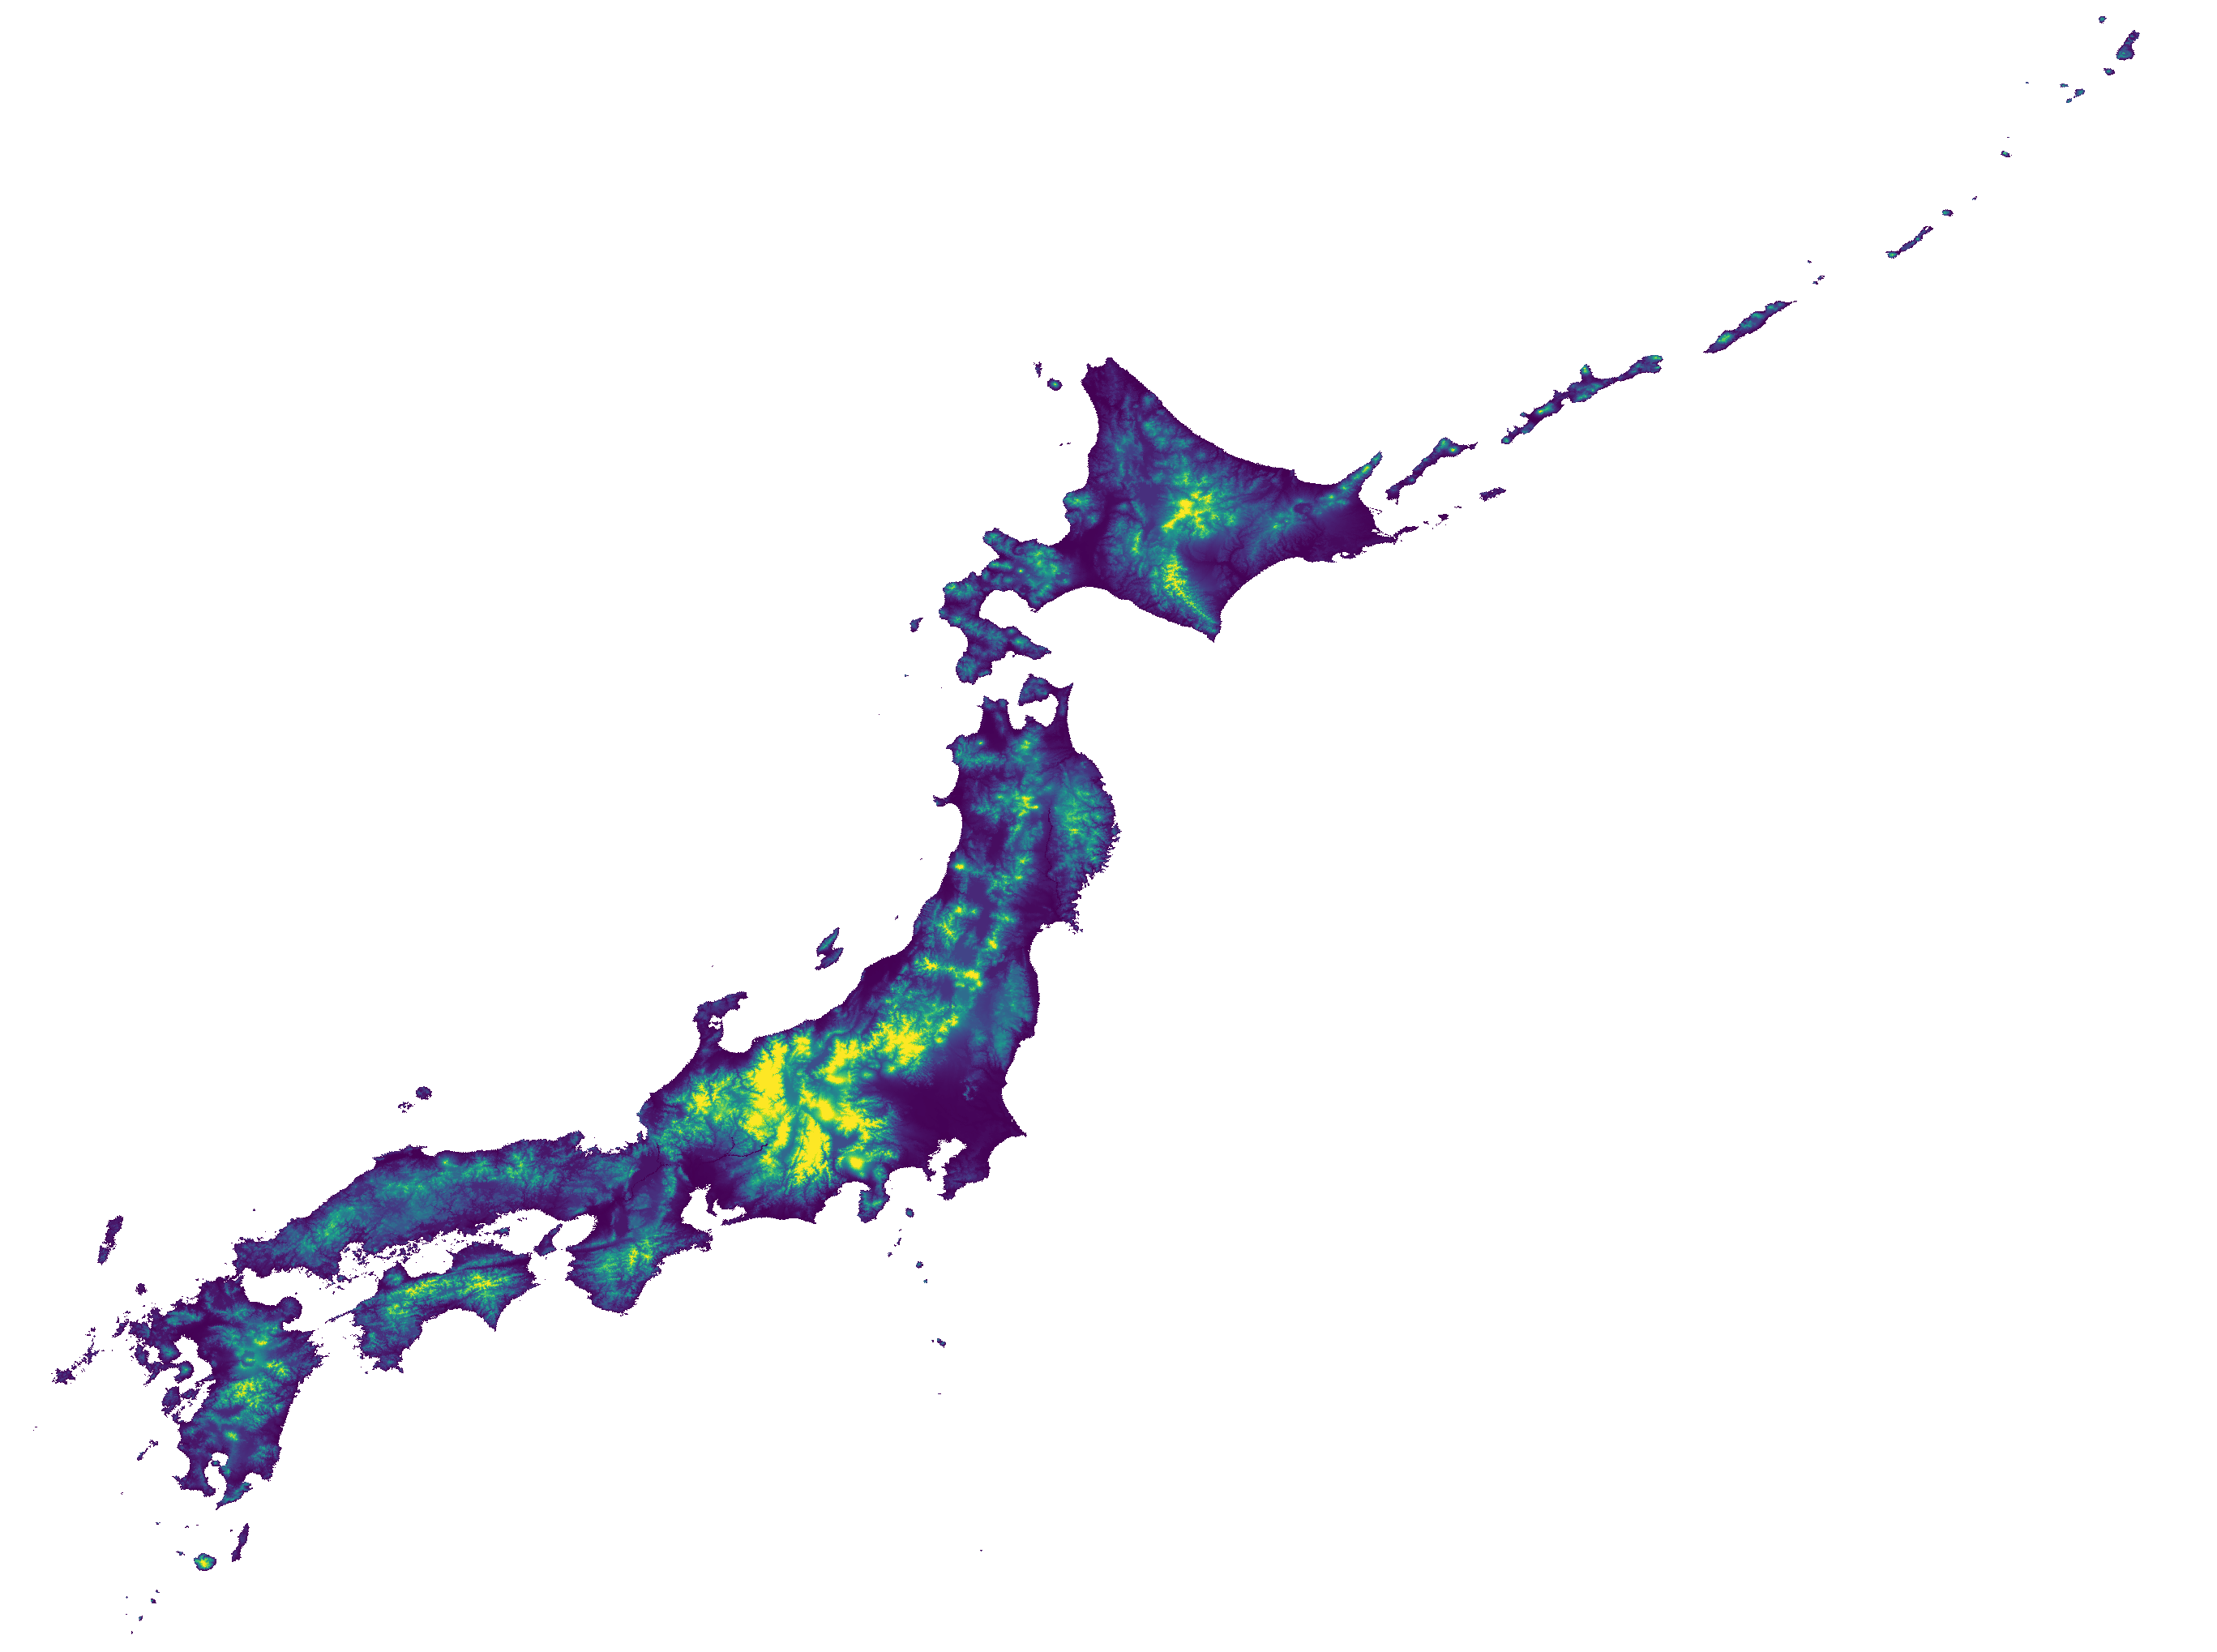

In [15]:
(ggplot() 
 + geom_rect(**jp_bbox, fill='#aadaff', alpha=0.2)
 + geom_text(aes("x", "y", label="label"), data=labels, color='#578bcc', size=11, fontface='italic', family="Courier")
 + geom_imshow(jp_arr_nan, "viridis", extent=jp_ext, vmax=1500)
 + coord_fixed(xlim=[128,147], ylim=[30, 46])
 + theme_bw() 
 + theme(axis_title="blank", plot_title=element_text(face="bold"))
 + ggsize(800, 680)
 + ggtitle("Japan Digital Elevation Model") 
 + labs(caption="Japan DEM (c) USGS.\n" +
            "Processed for Japan by Skinner Regional Systems Analysis.\n" +
            "Cambridge: Center for Geographic Analysis, Harvard University, 2015.")
)